In [1]:
] activate .

In [2]:
# ] instantiate

In [3]:
using StableDQMC, GenericSVD, JacobiSVD, LinearAlgebra, Plots, Statistics, LaTeXStrings

pyplot();
PyPlot.plt.style.use("publication_tex")
default(
    framestyle = :grid,
    grid = true,
    guidefont=font(15),
#     framestyle = :box,
#     grid = false,
#     guidefont=font(18),
    legend = true,
    size = (1.6*360, 360),
    xtickfont=font(13), 
    ytickfont=font(13), 
    legendfont=font(12),
    linewidth = 1.5
);

# default(
#     framestyle = :box,
#     legend = true,
#     grid = false,
#     size = (1.5*250, 250),
#     xtickfont=font(8), 
#     ytickfont=font(8), 
#     guidefont=font(11),
#     legendfont=font(8),
#     linewidth = 1
# );

In [4]:
# Some basic tests
B = rand(5,5) # regular matrix
N = 10
@assert isapprox(StableDQMC.calc_product_chain(B, N)[1], B^N)
@assert isapprox(UDV_to_mat(calc_product_chain_stabilized(B, N, gesdd)[1:3]...), B^N)
@assert isapprox(UDV_to_mat(calc_product_chain_stabilized(B, N, gesvd)[1:3]...), B^N)
@assert isapprox(UDV_to_mat(calc_product_chain_stabilized(B, N, genericsvd)[1:3]...), B^N)
@assert isapprox(UDT_to_mat(calc_product_chain_stabilized(B, N, udt)[1:3]...), B^N)
# @assert isapprox(StableDQMC.calc_product_chain_stabilized(B, N, gesvj)[1], B^N)

┌ Warning: UDT_to_mat! probably shouldn't be called here
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:532


# Non-interacting system

In [5]:
n = 8
t = -1
μ = -0.1
Δτ = 0.1
T = diagm(-1 => fill(-t, n-1), 1 => fill(-t, n-1), 0 => fill(μ, n))

# PBC
T[1,end] = -t
T[end,1] = -t

# B from spin-fermion model
#B = [0.975173 0.0971936 0.192475 0.0191836 0.0 0.0 0.0 0.0; 0.0971936 0.975173 0.0191836 0.192475 0.0 0.0 0.0 0.0; 0.192475 0.0191836 0.975173 0.0971936 0.0 0.0 0.0 0.0; 0.0191836 0.192475 0.0971936 0.975173 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.975173 -0.192475 -0.0971936 0.0191836; 0.0 0.0 0.0 0.0 -0.192475 0.975173 0.0191836 -0.0971936; 0.0 0.0 0.0 0.0 -0.0971936 0.0191836 0.975173 -0.192475; 0.0 0.0 0.0 0.0 0.0191836 -0.0971936 -0.192475 0.975173]

B = exp(-Δτ .* T)

8×8 Array{Float64,2}:
  1.02018      -0.101511      0.00506711   …   0.00506711   -0.101511   
 -0.101511      1.02018      -0.101511        -0.000168847   0.00506711 
  0.00506711   -0.101511      1.02018          8.43393e-6   -0.000168847
 -0.000168847   0.00506711   -0.101511        -0.000168847   8.43393e-6 
  8.43393e-6   -0.000168847   0.00506711       0.00506711   -0.000168847
 -0.000168847   8.43393e-6   -0.000168847  …  -0.101511      0.00506711 
  0.00506711   -0.000168847   8.43393e-6       1.02018      -0.101511   
 -0.101511      0.00506711   -0.000168847     -0.101511      1.02018    

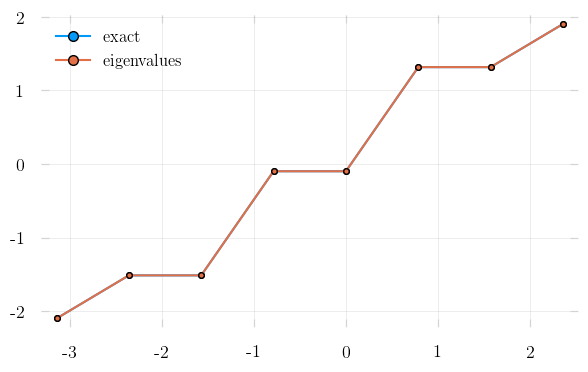

C:\Users\carsten\Anaconda2\envs\py35\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [6]:
# Compare to exact discretized energies
ks = LinRange(-pi, pi, n+1)[1:end-1]
ϵ(k) = -2*t*cos(k) + μ
sort(ϵ.(ks))

plot(ks, sort(ϵ.(ks)), marker=true, label="exact")
plot!(ks, eigvals(T), marker=true, label="eigenvalues")

In [7]:
cond(B)

1.4918246976412697

In [8]:
kappa(N) = exp(4abs(t)*N*Δτ)

kappa (generic function with 1 method)

In [9]:
cond(B)

1.4918246976412697

In [10]:
kappa(1)

1.4918246976412703

In [11]:
estimate_breakdown(sigdigits) = sigdigits * log(10) / (4 * abs(t) * Δτ)

estimate_breakdown (generic function with 1 method)

In [12]:
estimate_breakdown(17)

97.85986645224693

In [34]:
Bbig = BigFloat.(B)
N = 500

setprecision(100) do
    global svs_genericsvd = calc_product_chain_stabilized(Bbig, N, genericsvd)[4];
end
svs_qr_udt = calc_product_chain_stabilized(B, N, udt)[4];
svs_gesvd = calc_product_chain_stabilized(B, N, gesvd)[4];
svs_gesdd = calc_product_chain_stabilized(B, N, gesdd)[4];
svs_gesvj = calc_product_chain_stabilized(B, N, gesvj)[4];

In [14]:
cond(exp.(svs_qr_udt[end,:]))

9.032467210156366e85

In [15]:
kappa(N)

7.225973768125749e86

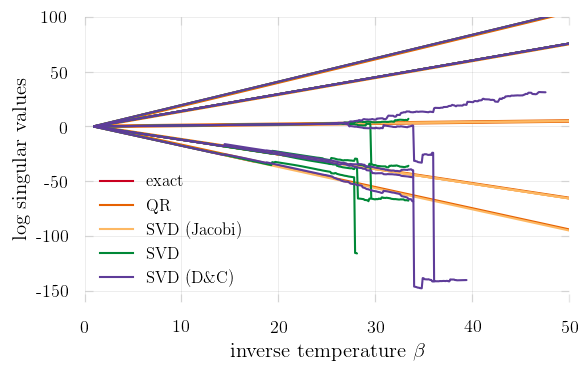

In [20]:
betas = range(1, N * 0.1, length=N)
plot(betas, svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_qr_udt, color="#E66101", labels = reshape(["QR", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_gesvj, color="#FDB863", labels = reshape(["SVD (Jacobi)", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_gesvd, color="#008837", labels = reshape(["SVD", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_gesdd, color="#5E3C99", labels = reshape(["SVD (D\\&C)", "", "","", "","", "", ""], (1,8)))

ylabel!("log singular values")
xlabel!(L"inverse temperature $\beta$")
ylims!(-160, 100)
xlims!(0., 50.)
savefig("decomp_comparison_simple.pdf")

## Stabilization - principle issue

In [35]:
svs_naive = calc_product_chain(B, N)[2];

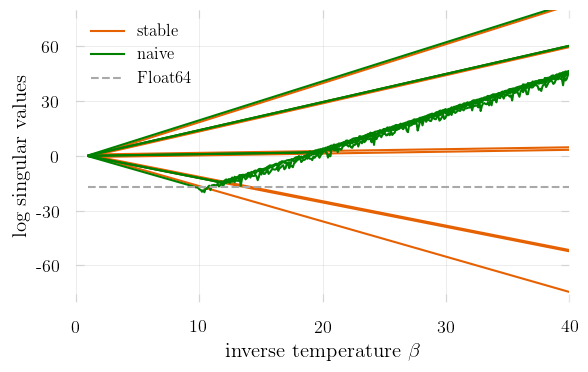

In [36]:
betas = range(1, N * 0.1, length=N)
# plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot(betas, svs_qr_udt, color="#E66101", labels = reshape(["stable", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_naive, color=:green, labels = reshape(["naive", "", "","", "","", "", ""], (1,8)))
plot!(1:40, fill(-17, 40), color=:darkgray, linestyle=:dash, label = "Float64")

ylabel!("log singular values")
xlabel!(L"inverse temperature $\beta$")
ylims!(-80, 80)
xlims!((0., 40.))
savefig("naive_vs_stable.pdf")

In [37]:
using DoubleFloats
Bdb64 = Double64.(B)
svs_naive = calc_product_chain(Bdb64, N)[2];

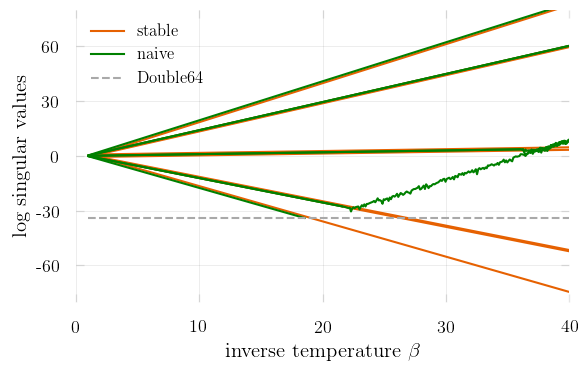

In [38]:
betas = range(1, N * 0.1, length=N)
# plot(svs_genericsvd, color="#CA0020", labels = reshape(["exact", "", "","", "","", "", ""], (1,8)))
plot(betas, svs_qr_udt, color="#E66101", labels = reshape(["stable", "", "","", "","", "", ""], (1,8)))
plot!(betas, svs_naive, color=:green, labels = reshape(["naive", "", "","", "","", "", ""], (1,8)))
plot!(1:40, fill(-34, 40), color=:darkgray, linestyle=:dash, label = "Double64")

ylabel!("log singular values")
xlabel!(L"inverse temperature $\beta$")
ylims!(-80, 80)
xlims!((0., 40.))
savefig("naive_vs_stable_db64.pdf")

In [21]:
# using PyPlot
# plt.style.use("publication_tex")
# function Inf2NaN(x)
#     y = copy(x)
#     y[findall(i -> (i == Inf || i == -Inf), y)] .= NaN
#     y = Float64.(y)
# end

# # PyPlot
# plot(Inf2NaN(svs_genericsvd), color="#CA0020", lw=2, label = "exact")
# plot(svs_qr_udt, color="#E66101", lw=2, label = "QR")
# plot(svs_gesvj, color="#FDB863", lw=2, label = "SVD (Jacobi)")
# plot(svs_gesvd, color="#008837", lw=2, label = "SVD")
# plot(svs_gesdd, color="#5E3C99", lw=2, label = "SVD (D\\&C)")

# handles, labels = gca().get_legend_handles_labels()
# ulabels = unique(labels)
# uhandles = Vector{eltype(handles)}(undef, 0)
# for l in ulabels
#     push!(uhandles, handles[findfirst(isequal(l), labels)])
# end
# legend(uhandles, ulabels, loc="lower left", prop=Dict("size" => 16))

# ylabel("log singular values")
# xlabel("length of product chain")
# ylim(-150, 85)
# xlim(0., 290.)
# savefig("decomp_comparison.pdf")

# Accuracy: Greens

In [39]:
using DataStructures

In [40]:
function accuracy_greens(B; svdinversion=inv_one_plus_udv)
    Bbig = BigFloat.(B)
    
    Δs_qr    = SortedDict{Int, Float64}()
    Δs_gesvd = SortedDict{Int, Float64}()
    Δs_gesdd = SortedDict{Int, Float64}()
    Δs_gesvj = SortedDict{Int, Float64}()
    
    for beta in range(5, 40, step=5)
        N = Int(beta * 10)
        
        local G_genericsvd
        setprecision(1000) do
            U_genericsvd, D_genericsvd, X_genericsvd = calc_product_chain_stabilized(Bbig, N, genericsvd);
            G_genericsvd = inv(I + U_genericsvd * Diagonal(D_genericsvd) * X_genericsvd)
        end
        
        # Bchain
        U_qr_udt, D_qr_udt, X_qr_udt = calc_product_chain_stabilized(B, N, udt);
        U_gesvd, D_gesvd, X_gesvd    = calc_product_chain_stabilized(B, N, gesvd);
        U_gesdd, D_gesdd, X_gesdd    = calc_product_chain_stabilized(B, N, gesdd);
        U_gesvj, D_gesvj, X_gesvj    = calc_product_chain_stabilized(B, N, gesvj);
        
        # inversion
        G_qr_udt = inv_one_plus_udt(U_qr_udt, D_qr_udt, X_qr_udt)
        G_gesvd  = svdinversion(U_gesvd, D_gesvd, X_gesvd)
        G_gesdd  = svdinversion(U_gesdd, D_gesdd, X_gesdd)
        G_gesvj  = svdinversion(U_gesvj, D_gesvj, X_gesvj)
        
        Δs_qr[beta]    = maximum(abs.(G_qr_udt - G_genericsvd))
        Δs_gesvd[beta] = maximum(abs.(G_gesvd - G_genericsvd))
        Δs_gesdd[beta] = maximum(abs.(G_gesdd - G_genericsvd))
        Δs_gesvj[beta] = maximum(abs.(G_gesvj - G_genericsvd))
    end
    

    return Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj
end

accuracy_greens (generic function with 1 method)

In [41]:
Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj = accuracy_greens(B);

┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_u

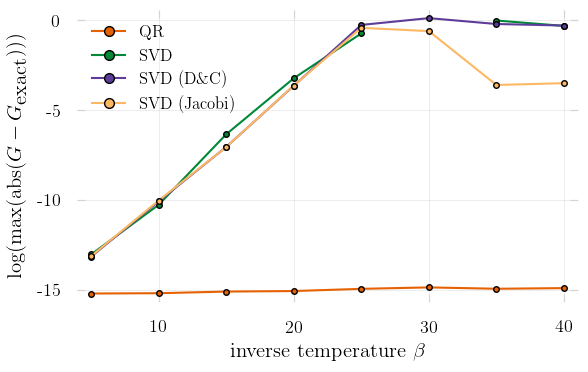

In [42]:
betas = collect(keys(Δs_qr))
p = plot(betas, log.(10, values(Δs_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G - G_{\textrm{exact}})))")
# ylims!(0., 1e-3)
savefig("accuracy_greens_svd_regularinv.pdf")

In [43]:
Δs_qr, Δs_gesvd, Δs_gesdd, Δs_gesvj = accuracy_greens(B, svdinversion=inv_one_plus_udv_loh);

┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_udt`
└ @ StableDQMC C:\Users\carsten\Desktop\StableDQMC.jl\src\qr.jl:98
┌ Warning: Calling somewhat inefficient and potentially inaccurate `inv_one_plus_u

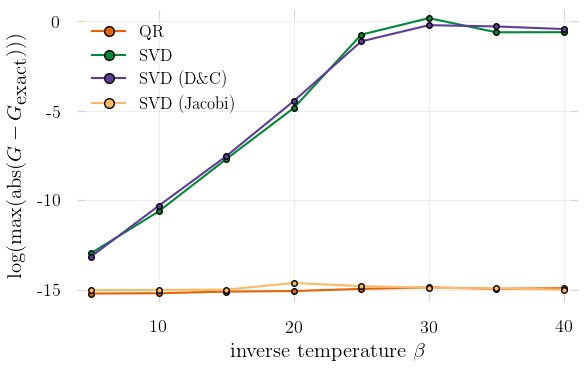

In [44]:
betas = collect(keys(Δs_qr))
p = plot(betas, log.(10, values(Δs_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{max}(\textrm{abs}(G - G_{\textrm{exact}})))")
savefig("accuracy_greens_svd_loh.pdf")

# Accuracy: Determinant

In [49]:
function det_G_udt(U,D,T)
  m = U' / T
  m[diagind(m)] .+= D
  u,d,t = udt(m)
  prod(1 ./ d)
end

function det_G_udv(U,D,Vd, udv=udv!)
  inner = copy(Vd')
  inner .+= U * Diagonal(D)
  I = udv(inner)
  prod(1 ./ I[2])
end

function det_G_udv_loh(U,D,Vd, udv=udv!)
  Dp = max.(D,1.)
  Dm = min.(D,1.)
  Dpinv = 1 ./ Dp

  l = copy(Vd')
  rmul!(l, Diagonal(Dpinv))

  r = copy(U)
  rmul!(r, Diagonal(Dm))

  u, d, vd = udv(l+r)

  m = inv_udv(u,d,vd)
  lmul!(Diagonal(Dpinv), m)
  u, d, vd = udv(m)

#   mul!(m, Vd', u)
  # return m, d, vd
#   rmul!(m, Diagonal(d))
#   m*vd
    prod(d)
end


function det_G_udv(U::Matrix{BigFloat},D,Vd::Matrix{BigFloat})
  inner = copy(Vd')
  inner .+= U * Diagonal(D)
  I = genericsvd!(inner)
  prod(1 ./ I[2])
end

absdiff(x,y) = abs(x-y)
reldiff(x, y) = abs((x - y) / (x + y))




function accuracy_determinant(B; svdinversion=det_G_udv)
    Bbig = BigFloat.(B)
    
    Δs_abs_qr    = SortedDict{Int, Float64}()
    Δs_abs_gesvd = SortedDict{Int, Float64}()
    Δs_abs_gesdd = SortedDict{Int, Float64}()
    Δs_abs_gesvj = SortedDict{Int, Float64}()
    
    Δs_rel_qr    = SortedDict{Int, Float64}()
    Δs_rel_gesvd = SortedDict{Int, Float64}()
    Δs_rel_gesdd = SortedDict{Int, Float64}()
    Δs_rel_gesvj = SortedDict{Int, Float64}()
    
    for beta in range(5, 40, step=5)
        N = Int(beta * 10)
        
        local det_genericsvd
        setprecision(1000) do
            U_genericsvd, D_genericsvd, X_genericsvd = calc_product_chain_stabilized(Bbig, N, genericsvd);
            det_genericsvd = det_G_udv(U_genericsvd, D_genericsvd, X_genericsvd)
        end
        
        # Bchain
        U_qr_udt, D_qr_udt, X_qr_udt = calc_product_chain_stabilized(B, N, udt);
        U_gesvd, D_gesvd, X_gesvd    = calc_product_chain_stabilized(B, N, gesvd);
        U_gesdd, D_gesdd, X_gesdd    = calc_product_chain_stabilized(B, N, gesdd);
        U_gesvj, D_gesvj, X_gesvj    = calc_product_chain_stabilized(B, N, gesvj);
        
        # inversion + det extraction
        det_qr_udt = det_G_udt(U_qr_udt, D_qr_udt, X_qr_udt)
        det_gesvd  = svdinversion(U_gesvd, D_gesvd, X_gesvd, gesvd!)
        det_gesdd  = svdinversion(U_gesdd, D_gesdd, X_gesdd, gesdd!)
        det_gesvj  = svdinversion(U_gesvj, D_gesvj, X_gesvj, StableDQMC.gesvj!)
        
        Δs_abs_qr[beta]    = absdiff(det_qr_udt, det_genericsvd)
        Δs_abs_gesvd[beta] = absdiff(det_gesvd, det_genericsvd)
        Δs_abs_gesdd[beta] = absdiff(det_gesdd, det_genericsvd)
        Δs_abs_gesvj[beta] = absdiff(det_gesvj, det_genericsvd)
        
        Δs_rel_qr[beta]    = reldiff(det_qr_udt, det_genericsvd)
        Δs_rel_gesvd[beta] = reldiff(det_gesvd, det_genericsvd)
        Δs_rel_gesdd[beta] = reldiff(det_gesdd, det_genericsvd)
        Δs_rel_gesvj[beta] = reldiff(det_gesvj, det_genericsvd)
    end
    

    return Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
            Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj
end

accuracy_determinant (generic function with 1 method)

In [50]:
Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj = accuracy_determinant(B, svdinversion=det_G_udv)

(SortedDict(5=>2.27871e-27,10=>3.48077e-38,15=>1.25375e-49,20=>4.12989e-61,25=>4.19818e-73,30=>1.13429e-84,35=>1.02002e-95,40=>4.05973e-107), SortedDict(5=>3.16486e-26,10=>7.30843e-34,15=>3.51485e-43,20=>2.61035e-50,25=>1.18808e-59,30=>Inf,35=>9.17596e-80,40=>4.45448e-90), SortedDict(5=>1.75436e-25,10=>1.23219e-34,15=>4.62189e-42,20=>3.00306e-52,25=>5.99481e-59,30=>3.42454e-70,35=>9.55937e-82,40=>2.63012e-93), SortedDict(5=>1.9622e-27,10=>4.57097e-40,15=>1.36556e-49,20=>7.58688e-61,25=>2.81688e-72,30=>7.11832e-84,35=>1.96806e-95,40=>7.80673e-107), SortedDict(5=>1.09819e-15,10=>4.50618e-15,15=>4.82752e-15,20=>5.09667e-15,25=>1.75072e-15,30=>1.65611e-15,35=>5.33514e-15,40=>7.71777e-15), SortedDict(5=>1.52526e-14,10=>9.46143e-11,15=>1.35338e-8,20=>0.000322038,25=>0.0521276,30=>NaN,35=>0.979589,40=>0.998821), SortedDict(5=>8.45485e-14,10=>1.59518e-11,15=>1.77964e-7,20=>3.70604e-6,25=>0.199996,30=>0.999999,35=>0.999988,40=>1.0), SortedDict(5=>9.45653e-16,10=>5.91753e-17,15=>5.25803e-15,20=>

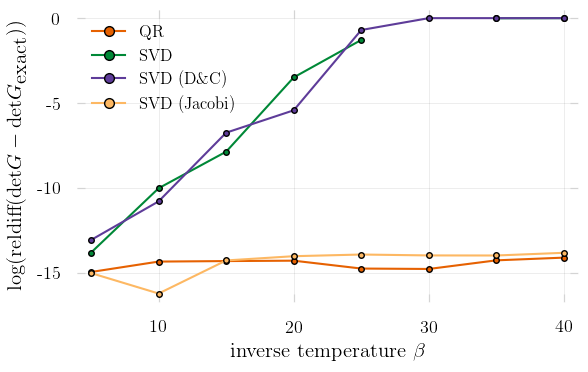

In [51]:
betas = collect(keys(Δs_rel_qr))
p = plot(betas, log.(10, values(Δs_rel_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_rel_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_rel_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_rel_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{reldiff}(\textrm{det}G - \textrm{det}G_{\textrm{exact}}))")
savefig("accuracy_det_svd_regularinv.pdf")

In [52]:
Δs_abs_qr, Δs_abs_gesvd, Δs_abs_gesdd, Δs_abs_gesvj,
Δs_rel_qr, Δs_rel_gesvd, Δs_rel_gesdd, Δs_rel_gesvj = accuracy_determinant(B, svdinversion=det_G_udv_loh)

(SortedDict(5=>2.27871e-27,10=>3.48077e-38,15=>1.25375e-49,20=>4.12989e-61,25=>4.19818e-73,30=>1.13429e-84,35=>1.02002e-95,40=>4.05973e-107), SortedDict(5=>6.97271e-25,10=>2.41558e-31,15=>2.1988e-38,20=>2.57e-45,25=>6.17355e-52,30=>1.58675e-51,35=>3.15658e-50,40=>4.29195e-50), SortedDict(5=>4.79573e-24,10=>3.60656e-31,15=>1.65306e-38,20=>2.27847e-45,25=>2.76477e-51,30=>3.26114e-52,35=>2.54278e-54,40=>3.95811e-60), SortedDict(5=>3.17389e-27,10=>1.12978e-38,15=>1.41901e-49,20=>7.68412e-61,25=>2.97606e-72,30=>6.7966e-84,35=>1.97976e-95,40=>6.95514e-107), SortedDict(5=>1.09819e-15,10=>4.50618e-15,15=>4.82752e-15,20=>5.09667e-15,25=>1.75072e-15,30=>1.65611e-15,35=>5.33514e-15,40=>7.71777e-15), SortedDict(5=>3.36039e-13,10=>3.12719e-8,15=>0.000845923,20=>0.969434,25=>1.0,30=>1.0,35=>1.0,40=>1.0), SortedDict(5=>2.31122e-12,10=>4.66901e-8,15=>0.00063691,20=>0.965658,25=>1.0,30=>1.0,35=>1.0,40=>1.0), SortedDict(5=>1.52961e-15,10=>1.46261e-15,15=>5.46386e-15,20=>9.48292e-15,25=>1.24107e-14,30=>9

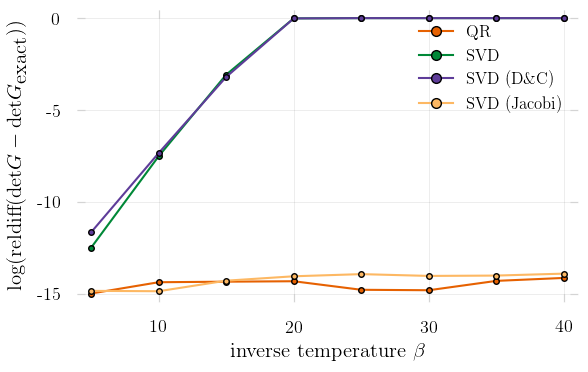

In [53]:
betas = collect(keys(Δs_rel_qr))
p = plot(betas, log.(10, values(Δs_rel_qr)), color="#E66101", marker=true, label="QR")
plot!(betas, log.(10, values(Δs_rel_gesvd)), color="#008837", marker=true, label="SVD")
plot!(betas, log.(10, values(Δs_rel_gesdd)), color="#5E3C99", marker=true, label="SVD (D\\&C)")
plot!(betas, log.(10, values(Δs_rel_gesvj)), color="#FDB863", marker=true, label="SVD (Jacobi)")

xlabel!(L"inverse temperature $\beta$")
ylabel!(L"\log(\textrm{reldiff}(\textrm{det}G - \textrm{det}G_{\textrm{exact}}))")
savefig("accuracy_det_svd_loh.pdf")

# Performance: Bchain

In [290]:
using BenchmarkTools

In [365]:
function benchmark_Bchain(B)
    Bbig = BigFloat.(B)
    
    ts_qr    = Dict{Int, Float64}()
    ts_gesvd = Dict{Int, Float64}()
    ts_gesdd = Dict{Int, Float64}()
    ts_gesvj = Dict{Int, Float64}()
    
    for beta in [5, 10, 20, 30, 40]
        N = Int(beta * 10)
        
        tqr    = @belapsed calc_product_chain_stabilized($B, $N, $udt);
        tgesvd = @belapsed calc_product_chain_stabilized($B, $N, $gesvd)
        tgesdd = @belapsed calc_product_chain_stabilized($B, $N, $gesdd);
        tgesvj = @belapsed calc_product_chain_stabilized($B, $N, $gesvj);
        
        ts_qr[beta]    = 1
        ts_gesvd[beta] = tgesvd / tqr
        ts_gesdd[beta] = tgesdd / tqr
        ts_gesvj[beta] = tgesvj / tqr
    end 
    
    betas = collect(keys(ts_qr)) .* 10
    p = plot(betas, collect(values(ts_qr)), color="#E66101", marker=:dot, label="QR")
    plot!(betas, collect(values(ts_gesvd)), color="#008837", marker=:dot, label="SVD")
    plot!(betas, collect(values(ts_gesdd)), color="#5E3C99", marker=:dot, label="SVD (D\\&C)")
    plot!(betas, collect(values(ts_gesvj)), color="#FDB863", marker=:dot, label="SVD (Jacobi)")
    
    xlabel!("length of product chain")
    ylabel!("slowdown relative to QR")
    savefig("performance_Bchain.pdf")
    p
end

benchmark_Bchain (generic function with 1 method)

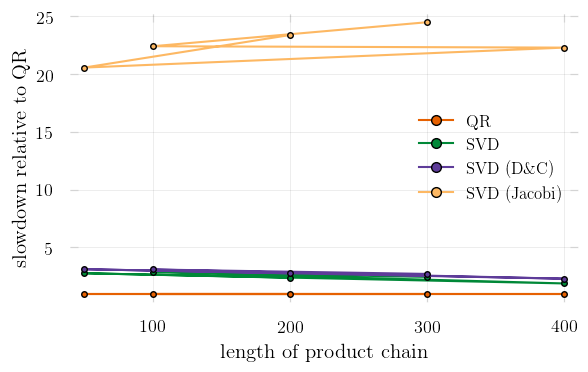

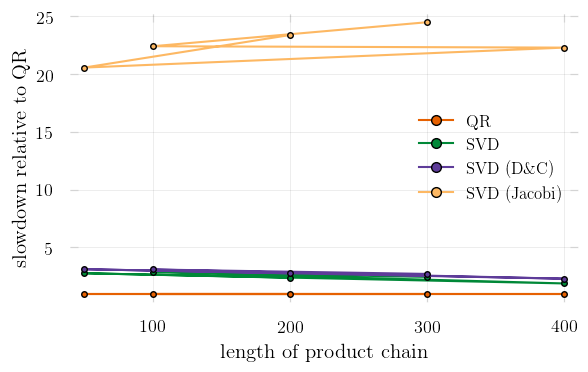

In [366]:
benchmark_Bchain(B);